Tests of ACF calculation:
* using my own written function (Pearson)
* using acf from statsmodels (I am using it in timescales)
* using pearsonr from scipy (Siegle paper use it)

Tests of ACF calculation vs length of the signal

In [2]:
import pandas as pd
import numpy as np
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading test data 

In [3]:
project_folder = "Q:\\Personal\\Irina\\projects\\isttc\\"

nifty len 3322


,Close
Date,
2007-11-27,962.9
2007-11-28,893.9
2007-11-29,884.2


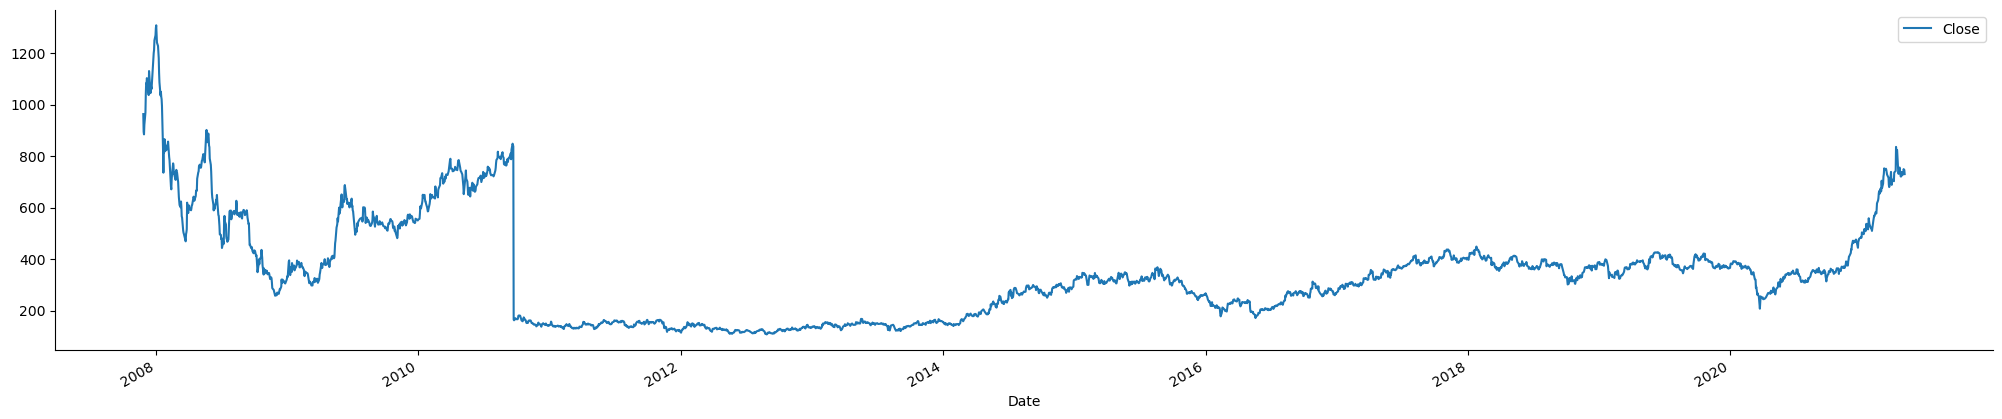

In [7]:
# indian stock market index
nifty = pd.read_csv(project_folder + 'nifty.csv',
                     usecols=['Date', "Close"],
                     parse_dates=['Date'])

nifty.set_index("Date", inplace=True) #setting "Date" as index
nifty.asfreq("b", method='ffill') #setting frequency to business days and filling missing days with previous values

nifty.plot(figsize=(25,5))
sns.despine()

print('nifty len {}'.format(len(nifty)))
nifty.head(3)

#### Def my implementation

In [29]:
def my_autocorr(signal_, lag_=1, verbose=True):
    # autocorrelation for 1 lag
    if verbose:
        print('Calc for lag {}, input length {}'.format(lag_, signal_.shape))

    signal_mean = np.mean(signal_)
    denominator = sum((signal_ - signal_mean) ** 2) 
    if verbose:
        print('y_mean = {}, denominator = {}'.format(signal_mean, denominator))
    numerator_p1 = signal_[lag_:] - signal_mean
    numerator_p2 = signal_[:-lag_] - signal_mean 
    if verbose:
        print('shape numerator_p1 {}, numerator_p2 {}'.format(numerator_p1.shape, numerator_p2.shape))
    numerator = sum(numerator_p1 * numerator_p2) 
    ac_lag = numerator / denominator
    if verbose:
        print('acf_lag {}'.format(ac_lag))
    return ac_lag

def my_acf(signal_, nlags=2, verbose=True):
    # acf
    acf = [1] 
    for i in range(1, (nlags + 1)):
        acf.append(my_autocorr(signal_, i, verbose)) 
    return np.array(acf)

In [28]:
def my_autocorr_pearsonr(signal_, lag_=1, verbose=True):
    # autocorrelation for 1 lag, using pearsonr from scipy
    if verbose:
        print('Calc for lag {}, input length {}'.format(lag_, signal_.shape))

    r, p = pearsonr(signal_[lag_:], signal_[:-lag_])
    
    if verbose:
        print('ac_lag {}'.format(r))
    return r  

def my_acf_pearsonr(signal_, nlags=2, verbose=True):
    # acf
    acf = [1] 
    for i in range(1, (nlags + 1)):
        acf.append(my_autocorr_pearsonr(signal_, i, verbose)) 
    return np.array(acf)

In [44]:
def my_autocorr_pearson_style(signal_, lag_=1, verbose=True):
    # autocorrelation for 1 lag
    if verbose:
        print('Calc for lag {}, input length {}'.format(lag_, signal_.shape))

    #signal_mean = np.mean(signal_)
    denominator = np.sqrt(sum((signal_[lag_:] - np.mean(signal_[lag_:])) ** 2) * sum((signal_[:-lag_] - np.mean(signal_[:-lag_])) ** 2))
    
    #denominator = sum((signal_ - signal_mean) ** 2) 
    # if verbose:
    #     print('y_mean = {}, denominator = {}'.format(signal_mean, denominator))
    numerator_p1 = signal_[lag_:] - np.mean(signal_[lag_:])
    numerator_p2 = signal_[:-lag_] - np.mean(signal_[:-lag_]) 
    if verbose:
        print('shape numerator_p1 {}, numerator_p2 {}'.format(numerator_p1.shape, numerator_p2.shape))
    numerator = sum(numerator_p1 * numerator_p2) 
    ac_lag = numerator / denominator
    if verbose:
        print('acf_lag {}'.format(ac_lag))
    return ac_lag

def my_acf_pearson_style(signal_, nlags=2, verbose=True):
    # acf
    acf = [1] 
    for i in range(1, (nlags + 1)):
        acf.append(my_autocorr_pearson_style(signal_, i, verbose)) 
    return np.array(acf)

#### Calc for the full signal

In [50]:
acf_my = my_acf(nifty.iloc[:,0].values, nlags=10, verbose=False)
acf_my_pearsonr = my_acf_pearsonr(nifty.iloc[:,0].values, nlags=10, verbose=False)
acf_my_pearson_style = my_acf_pearson_style(nifty.iloc[:,0].values, nlags=10, verbose=False)
#acf_statsmodels = tsaplots.acf(nifty.iloc[:,0].values,nlags=10)
acf_statstools = acf(nifty.iloc[:,0].values,nlags=10)

print('acf_my {}, \nacf_statstools {}, \nacf_my_pearson_style {} \nacf_my_pearsonr {}'.format(acf_my, acf_statstools, 
                                                                                              acf_my_pearson_style, acf_my_pearsonr))

acf_my [1.         0.99415236 0.98830437 0.98242585 0.97623761 0.97026137
 0.96384059 0.95703591 0.95032913 0.943514   0.93675867], 
acf_statstools [1.         0.99415236 0.98830437 0.98242585 0.97623761 0.97026137
 0.96384059 0.95703591 0.95032913 0.943514   0.93675867], 
acf_my_pearson_style [1.         0.99629284 0.99229802 0.98821361 0.98397931 0.98011499
 0.97615109 0.97205346 0.9679751  0.96389421 0.95979841] 
acf_my_pearsonr [1.         0.99629284 0.99229802 0.98821361 0.98397931 0.98011499
 0.97615109 0.97205346 0.9679751  0.96389421 0.95979841]


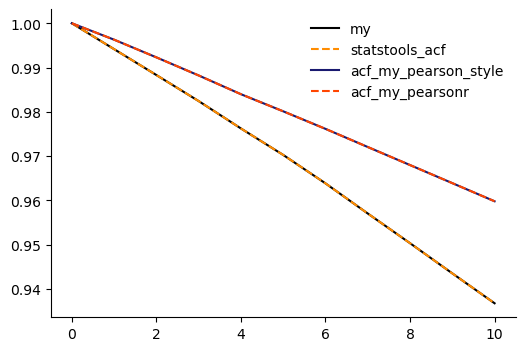

In [58]:
fig, axes = plt.subplots(1,1, figsize=(6,4))

t_lags = np.linspace(0,10,10+1)

axes.plot(t_lags, acf_my, label='my', color='k')
axes.plot(t_lags, acf_statstools, label='statstools_acf', color='darkorange', linestyle='dashed')
axes.plot(t_lags, acf_my_pearson_style, label='acf_my_pearson_style', color='midnightblue')
axes.plot(t_lags, acf_my_pearsonr, label='acf_my_pearsonr', color='orangered', linestyle='dashed')

axes.legend(frameon=False)

sns.despine()

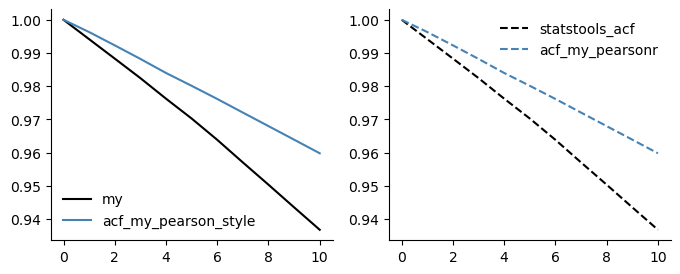

In [66]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

axes[0].plot(t_lags, acf_my, label='my', color='k')
axes[0].plot(t_lags, acf_my_pearson_style, label='acf_my_pearson_style', color='steelblue')

axes[1].plot(t_lags, acf_statstools, label='statstools_acf', color='k', linestyle='dashed')
axes[1].plot(t_lags, acf_my_pearsonr, label='acf_my_pearsonr', color='steelblue', linestyle='dashed')

axes[0].legend(frameon=False)
axes[1].legend(frameon=False)

sns.despine()

#### Calc with short sequence

In [90]:
pal_data_len = sns.color_palette('Greys', 12)

In [91]:
data_len_l = [10,20,30,40,50, 60, 70, 80, 90, 100, 1000]

In [92]:
acf_my_dict = {}

for data_len in data_len_l:
    data_subset = nifty.iloc[:data_len, 0].values
    acf_my_dict[data_len] = {'acf': my_acf(data_subset, nlags=10, verbose=False)}

acf_my_dict['full_'+str(len(nifty))] = {'acf': acf_my}

In [94]:
acf_my_pearson_style_dict = {}

for data_len in data_len_l:
    data_subset = nifty.iloc[:data_len, 0].values
    acf_my_pearson_style_dict[data_len] = {'acf': my_acf_pearson_style(data_subset, nlags=10, verbose=False)}

acf_my_pearson_style_dict['full_'+str(len(nifty))] = {'acf': acf_my_pearson_style}

C:\Users\ipochino\AppData\Local\Temp\ipykernel_15588\874320989.py:17: RuntimeWarning: invalid value encountered in scalar divide
  ac_lag = numerator / denominator
C:\Users\ipochino\.conda\envs\isttc\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ipochino\.conda\envs\isttc\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


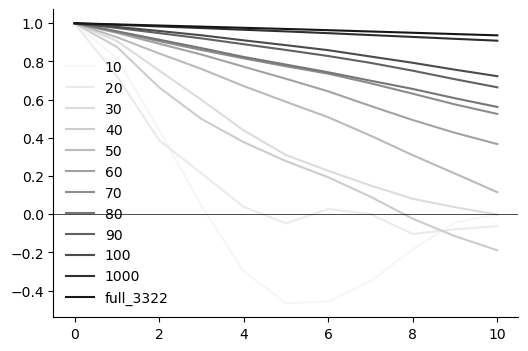

In [97]:
fig, axes = plt.subplots(1,1, figsize=(6,4))

t_lags = np.linspace(0,10,10+1)

i = 0
for k,v in acf_my_dict.items():
    axes.plot(t_lags, v['acf'], label=str(k), color=pal_data_len[i])
    i=i+1
axes.axhline(y=0, lw=0.5, c='k')

axes.legend(frameon=False)

sns.despine()

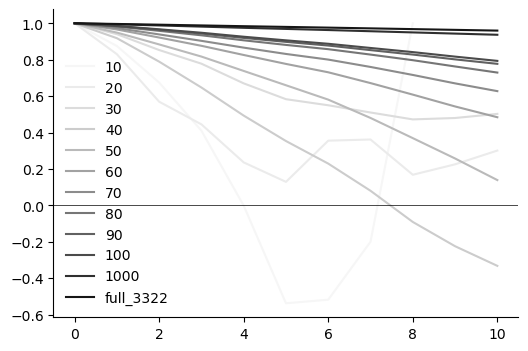

In [98]:
fig, axes = plt.subplots(1,1, figsize=(6,4))

t_lags = np.linspace(0,10,10+1)

i = 0
for k,v in acf_my_pearson_style_dict.items():
    axes.plot(t_lags, v['acf'], label=str(k), color=pal_data_len[i])
    i=i+1
axes.axhline(y=0, lw=0.5, c='k')

axes.legend(frameon=False)

sns.despine()

In [102]:
my_autocorr_pearson_style(nifty.iloc[:10, 0].values, lag_=10, verbose=True)

Calc for lag 10, input length (10,)
shape numerator_p1 (0,), numerator_p2 (0,)
acf_lag nan


C:\Users\ipochino\AppData\Local\Temp\ipykernel_15588\874320989.py:17: RuntimeWarning: invalid value encountered in scalar divide
  ac_lag = numerator / denominator


nan

In [105]:
my_autocorr(nifty.iloc[:10, 0].values, lag_=9, verbose=True)

Calc for lag 9, input length (10,)
y_mean = 1001.485, denominator = 64414.81525000006
shape numerator_p1 (1,), numerator_p2 (1,)
acf_lag -0.04427568819270972


-0.04427568819270972